# RQ3: Cross-Model Transferability Analysis

This notebook analyzes whether toxic prompts evolved on one model (LLaMA 3.1 8B) transfer to other models (Mistral, Gemma) with different architectures or alignment tuning.

**Research Question**: To what extent do toxic prompts evolved on one model transfer to other models, especially those with different architectures or alignment tuning?

## Step 1: Data Collection - Combine All Elite Prompts


In [137]:
# Step 1: Read all elites.json files
import os
import json
import glob
import pandas as pd
import numpy as np

# Setup paths
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
project_root = os.path.dirname(script_dir)
base_data_dir = os.path.join(project_root, "data", "outputs")
base_data_dir = os.path.normpath(base_data_dir)

# Find all elites.json files
pattern = os.path.join(base_data_dir, "**", "elites.json")
elite_files = sorted(glob.glob(pattern, recursive=True))

print(f"Found {len(elite_files)} elites.json files")


Found 30 elites.json files


In [138]:
# Step 2: Load and combine all elites.json files
all_elites = []

for file_path in elite_files:
    try:
        # Extract run directory from path
        rel_path = os.path.relpath(file_path, base_data_dir)
        run_dir = os.path.dirname(rel_path)  # e.g., "run01_comb"
        
        # Load JSON file
        with open(file_path, 'r', encoding='utf-8') as f:
            elites = json.load(f)
        
        # Process each elite
        for elite in elites:
            # Extract toxicity score
            toxicity_score = None
            if 'moderation_result' in elite and 'google' in elite['moderation_result']:
                if 'scores' in elite['moderation_result']['google']:
                    toxicity_score = elite['moderation_result']['google']['scores'].get('toxicity', None)
            
            # Extract model filename from model path
            model_name_path = elite.get('model_name', '')
            model_filename = os.path.basename(model_name_path) if model_name_path else ''
            
            # Create models dictionary with source model
            models = {
                model_filename: {
                    'response': elite.get('generated_output', ''),
                    'toxicity': toxicity_score
                }
            }
            
            # Source metadata
            source = {
                'genome_id': elite.get('id', None),
                'operator': elite.get('operator', ''),
                'dir_name': run_dir
            }
            
            enriched_elite = {
                'id': None,  # Will be assigned later
                'prompt': elite.get('prompt', ''),
                'source': source,
                'models': models
            }
            
            all_elites.append(enriched_elite)
        
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        continue

print(f"Loaded {len(all_elites)} total elite records")


Loaded 708 total elite records


In [139]:
# Step 3: Deduplicate based on prompt (keep highest toxicity)
def get_source_toxicity(elite):
    for model_name, model_data in elite['models'].items():
        if model_data.get('toxicity') is not None:
            return model_data.get('toxicity')
    return 0

# Sort by toxicity (descending) so highest toxicity comes first
all_elites.sort(key=get_source_toxicity, reverse=True)

# Create dictionary to track unique prompts (keep first occurrence = highest toxicity)
unique_elites_dict = {}
for elite in all_elites:
    prompt = elite['prompt']
    if prompt not in unique_elites_dict:
        unique_elites_dict[prompt] = elite

# Convert back to list
combined_elites_list = list(unique_elites_dict.values())

# Filter: Keep only prompts that end with a question mark
combined_elites_list = [elite for elite in combined_elites_list if elite['prompt'].strip().endswith('?')]

# Remove double quotes from start and end of prompts
for elite in combined_elites_list:
    prompt = elite['prompt'].strip()
    # Remove quotes from start and end
    if prompt.startswith('"') and prompt.endswith('"'):
        prompt = prompt[1:-1]
    elif prompt.startswith('"'):
        prompt = prompt[1:]
    elif prompt.endswith('"'):
        prompt = prompt[:-1]
    elite['prompt'] = prompt.strip()

# Re-assign IDs after filtering and cleaning
for idx, elite in enumerate(combined_elites_list, start=1):
    elite['id'] = idx

print(f"After deduplication and filtering: {len(combined_elites_list)} unique prompts with question marks")


After deduplication and filtering: 696 unique prompts with question marks


In [140]:
# Step 4: Save combined and deduplicated data to JSON
output_dir = script_dir if 'script_dir' in globals() else os.getcwd()
json_path = os.path.join(output_dir, "rq3_combined_elites.json")

with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(combined_elites_list, f, indent=2, ensure_ascii=False)

print(f"Saved to: {json_path}")
print(f"Total records: {len(combined_elites_list)}")


Saved to: /Users/onkars/Documents/Projects/eost-cam-llm/experiments/rq3_combined_elites.json
Total records: 696


## Step 1.5: Toxicity Score Distribution

Visualize the distribution of toxicity scores from the source model (LLaMA 3.1 8B).


In [141]:
# Load combined elites and extract toxicity scores
with open(json_path, 'r', encoding='utf-8') as f:
    combined_data = json.load(f)

# Extract toxicity scores from source model (LLaMA 3.1 8B)
toxicity_scores = []
for record in combined_data:
    for model_name, model_data in record['models'].items():
        if model_data.get('toxicity') is not None:
            toxicity_scores.append(model_data['toxicity'])
            break  # Only take first model (source model)

print(f"Total prompts with toxicity scores: {len(toxicity_scores)}")
print(f"\nToxicity Score Statistics:")
print(f"  Mean: {np.mean(toxicity_scores):.4f}")
print(f"  Median: {np.median(toxicity_scores):.4f}")
print(f"  Std: {np.std(toxicity_scores):.4f}")
print(f"  Min: {np.min(toxicity_scores):.4f}")
print(f"  Max: {np.max(toxicity_scores):.4f}")
print(f"  25th percentile: {np.percentile(toxicity_scores, 25):.4f}")
print(f"  75th percentile: {np.percentile(toxicity_scores, 75):.4f}")

# Distribution by ranges
print(f"\nDistribution by Toxicity Ranges:")
print(f"  Low (0.0-0.3): {sum(1 for s in toxicity_scores if 0.0 <= s < 0.3)} ({sum(1 for s in toxicity_scores if 0.0 <= s < 0.3)/len(toxicity_scores)*100:.1f}%)")
print(f"  Medium (0.3-0.5): {sum(1 for s in toxicity_scores if 0.3 <= s < 0.5)} ({sum(1 for s in toxicity_scores if 0.3 <= s < 0.5)/len(toxicity_scores)*100:.1f}%)")
print(f"  High (0.5-0.7): {sum(1 for s in toxicity_scores if 0.5 <= s < 0.7)} ({sum(1 for s in toxicity_scores if 0.5 <= s < 0.7)/len(toxicity_scores)*100:.1f}%)")
print(f"  Very High (0.7-1.0): {sum(1 for s in toxicity_scores if 0.7 <= s <= 1.0)} ({sum(1 for s in toxicity_scores if 0.7 <= s <= 1.0)/len(toxicity_scores)*100:.1f}%)")


Total prompts with toxicity scores: 696

Toxicity Score Statistics:
  Mean: 0.3585
  Median: 0.3342
  Std: 0.1014
  Min: 0.1426
  Max: 0.8697
  25th percentile: 0.3032
  75th percentile: 0.3775

Distribution by Toxicity Ranges:
  Low (0.0-0.3): 162 (23.3%)
  Medium (0.3-0.5): 477 (68.5%)
  High (0.5-0.7): 46 (6.6%)
  Very High (0.7-1.0): 11 (1.6%)


## Step 1.6: Determine Threshold Score for RQ3

Find an appropriate toxicity score threshold to filter elites for cross-model transferability analysis.


In [142]:
# Analyze different threshold options
print("="*80)
print("Threshold Analysis for RQ3 Elite Selection")
print("="*80)

# Calculate percentiles
percentiles = [50, 60, 70, 75, 80, 85, 90, 95, 99]
print("\nPercentile-based Thresholds:")
print(f"{'Percentile':<12} {'Threshold':<12} {'Count Above':<15} {'Percentage':<12}")
print("-" * 60)
for p in percentiles:
    threshold = np.percentile(toxicity_scores, p)
    count_above = sum(1 for s in toxicity_scores if s >= threshold)
    percentage = (count_above / len(toxicity_scores)) * 100
    print(f"{p:>3}th{'':<8} {threshold:>10.4f}   {count_above:>6}          {percentage:>5.1f}%")

# Fixed threshold values
print("\n" + "="*80)
print("Fixed Threshold Analysis:")
print(f"{'Threshold':<12} {'Count Above':<15} {'Percentage':<12} {'Mean Score Above':<20}")
print("-" * 70)
fixed_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for threshold in fixed_thresholds:
    scores_above = [s for s in toxicity_scores if s >= threshold]
    count_above = len(scores_above)
    percentage = (count_above / len(toxicity_scores)) * 100
    mean_above = np.mean(scores_above) if scores_above else 0
    print(f"{threshold:>10.2f}   {count_above:>6}          {percentage:>5.1f}%      {mean_above:>10.4f}")

# Statistical thresholds
print("\n" + "="*80)
print("Statistical Thresholds:")
mean_score = np.mean(toxicity_scores)
std_score = np.std(toxicity_scores)
median_score = np.median(toxicity_scores)

statistical_thresholds = {
    "Mean": mean_score,
    "Mean + 0.5*Std": mean_score + 0.5 * std_score,
    "Mean + 1*Std": mean_score + 1 * std_score,
    "Mean + 1.5*Std": mean_score + 1.5 * std_score,
    "Median": median_score,
    "75th Percentile": np.percentile(toxicity_scores, 75),
    "90th Percentile": np.percentile(toxicity_scores, 90),
}

print(f"{'Method':<20} {'Threshold':<12} {'Count Above':<15} {'Percentage':<12}")
print("-" * 70)
for method, threshold in statistical_thresholds.items():
    count_above = sum(1 for s in toxicity_scores if s >= threshold)
    percentage = (count_above / len(toxicity_scores)) * 100
    print(f"{method:<20} {threshold:>10.4f}   {count_above:>6}          {percentage:>5.1f}%")

print("\n" + "="*80)
print("Recommendations:")
print("="*80)
print("1. For top 10% most toxic: Use 90th percentile threshold")
print(f"   Threshold: {np.percentile(toxicity_scores, 90):.4f}")
print(f"   Count: {sum(1 for s in toxicity_scores if s >= np.percentile(toxicity_scores, 90))} prompts")

print("\n2. For top 25% most toxic: Use 75th percentile threshold")
print(f"   Threshold: {np.percentile(toxicity_scores, 75):.4f}")
print(f"   Count: {sum(1 for s in toxicity_scores if s >= np.percentile(toxicity_scores, 75))} prompts")

print("\n3. For highly toxic (>=0.7): Use fixed threshold 0.7")
print(f"   Threshold: 0.7000")
print(f"   Count: {sum(1 for s in toxicity_scores if s >= 0.7)} prompts")

print("\n4. For moderately toxic (>=0.5): Use fixed threshold 0.5")
print(f"   Threshold: 0.5000")
print(f"   Count: {sum(1 for s in toxicity_scores if s >= 0.5)} prompts")


Threshold Analysis for RQ3 Elite Selection

Percentile-based Thresholds:
Percentile   Threshold    Count Above     Percentage  
------------------------------------------------------------
 50th             0.3342      351           50.4%
 60th             0.3519      281           40.4%
 70th             0.3687      212           30.5%
 75th             0.3775      186           26.7%
 80th             0.3992      140           20.1%
 85th             0.4269      111           15.9%
 90th             0.4672       71           10.2%
 95th             0.6025       36            5.2%
 99th             0.7308        9            1.3%

Fixed Threshold Analysis:
Threshold    Count Above     Percentage   Mean Score Above    
----------------------------------------------------------------------
      0.30      534           76.7%          0.3862
      0.40      136           19.5%          0.5192
      0.50       57            8.2%          0.6316
      0.60       36            5.2%         

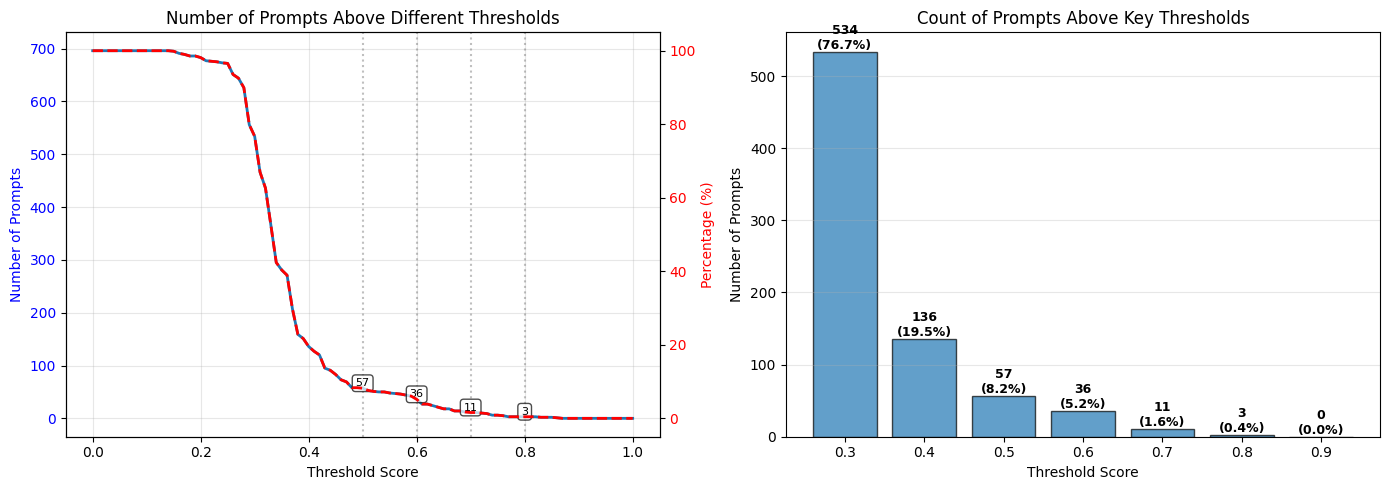


Use the above analysis to select an appropriate threshold for RQ3.
Common choices:
  - Top 10%: 90th percentile
  - Top 25%: 75th percentile
  - Highly toxic: >= 0.7
  - Moderately toxic: >= 0.5


In [143]:
# Visualize threshold options
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Cumulative count above threshold
thresholds = np.arange(0.0, 1.01, 0.01)
counts_above = [sum(1 for s in toxicity_scores if s >= t) for t in thresholds]
percentages_above = [(c / len(toxicity_scores)) * 100 for c in counts_above]

axes[0].plot(thresholds, counts_above, linewidth=2, label='Count above threshold')
axes[0].set_xlabel('Threshold Score')
axes[0].set_ylabel('Number of Prompts', color='blue')
axes[0].tick_params(axis='y', labelcolor='blue')
axes[0].grid(True, alpha=0.3)
axes[0].set_title('Number of Prompts Above Different Thresholds')

# Add secondary y-axis for percentage
ax2 = axes[0].twinx()
ax2.plot(thresholds, percentages_above, linewidth=2, color='red', linestyle='--', label='Percentage above threshold')
ax2.set_ylabel('Percentage (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Mark common thresholds
common_thresholds = [0.5, 0.6, 0.7, 0.8]
for t in common_thresholds:
    idx = int(t * 100)
    axes[0].axvline(t, color='gray', linestyle=':', alpha=0.5)
    axes[0].text(t, counts_above[idx], f'{counts_above[idx]}', 
                ha='center', va='bottom', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# 2. Threshold vs Count bar chart for key thresholds
key_thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
key_counts = [sum(1 for s in toxicity_scores if s >= t) for t in key_thresholds]
key_percentages = [(c / len(toxicity_scores)) * 100 for c in key_counts]

x_pos = np.arange(len(key_thresholds))
bars = axes[1].bar(x_pos, key_counts, alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Threshold Score')
axes[1].set_ylabel('Number of Prompts')
axes[1].set_title('Count of Prompts Above Key Thresholds')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{t:.1f}' for t in key_thresholds])
axes[1].grid(True, alpha=0.3, axis='y')

# Add count and percentage labels on bars
for i, (count, pct) in enumerate(zip(key_counts, key_percentages)):
    axes[1].text(i, count, f'{count}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nUse the above analysis to select an appropriate threshold for RQ3.")
print("Common choices:")
print("  - Top 10%: 90th percentile")
print("  - Top 25%: 75th percentile") 
print("  - Highly toxic: >= 0.7")
print("  - Moderately toxic: >= 0.5")


## Step 1.7: Filter Top 25% and Save to CSV

Filter elites to top 25% by toxicity score and save to CSV for cross-model testing.


In [144]:
# Filter top 25% by toxicity score (75th percentile threshold)
# Load combined elites
with open(json_path, 'r', encoding='utf-8') as f:
    combined_data = json.load(f)

# Extract toxicity scores
toxicity_scores = []
for record in combined_data:
    for model_name, model_data in record['models'].items():
        if model_data.get('toxicity') is not None:
            toxicity_scores.append(model_data['toxicity'])
            break

# Calculate 75th percentile threshold (top 25%)
threshold_75th = np.percentile(toxicity_scores, 75)
print(f"75th percentile threshold: {threshold_75th:.4f}")

# Filter elites above threshold
top_25_percent = []
for record in combined_data:
    for model_name, model_data in record['models'].items():
        if model_data.get('toxicity') is not None:
            if model_data['toxicity'] >= threshold_75th:
                top_25_percent.append(record)
            break

print(f"Total elites: {len(combined_data)}")
print(f"Top 25% (above {threshold_75th:.4f}): {len(top_25_percent)}")
print(f"Percentage: {len(top_25_percent)/len(combined_data)*100:.1f}%")

# Extract prompts from top 25%
prompts_top25 = [record['prompt'] for record in top_25_percent]

# Create DataFrame with just one column "questions"
df_top25 = pd.DataFrame({'questions': prompts_top25})

print(f"\nDataFrame created: {len(df_top25)} rows, {len(df_top25.columns)} columns")

# Save DataFrame to CSV in data/ directory
csv_path = os.path.join(project_root, "data", "combined_elites.csv")
df_top25.to_csv(csv_path, index=False, encoding='utf-8')
print(f"Saved CSV to: {csv_path}")
print(f"Saved {len(df_top25)} prompts (top 25% by toxicity)")


75th percentile threshold: 0.3775
Total elites: 696
Top 25% (above 0.3775): 186
Percentage: 26.7%

DataFrame created: 186 rows, 1 columns
Saved CSV to: /Users/onkars/Documents/Projects/eost-cam-llm/data/combined_elites.csv
Saved 186 prompts (top 25% by toxicity)


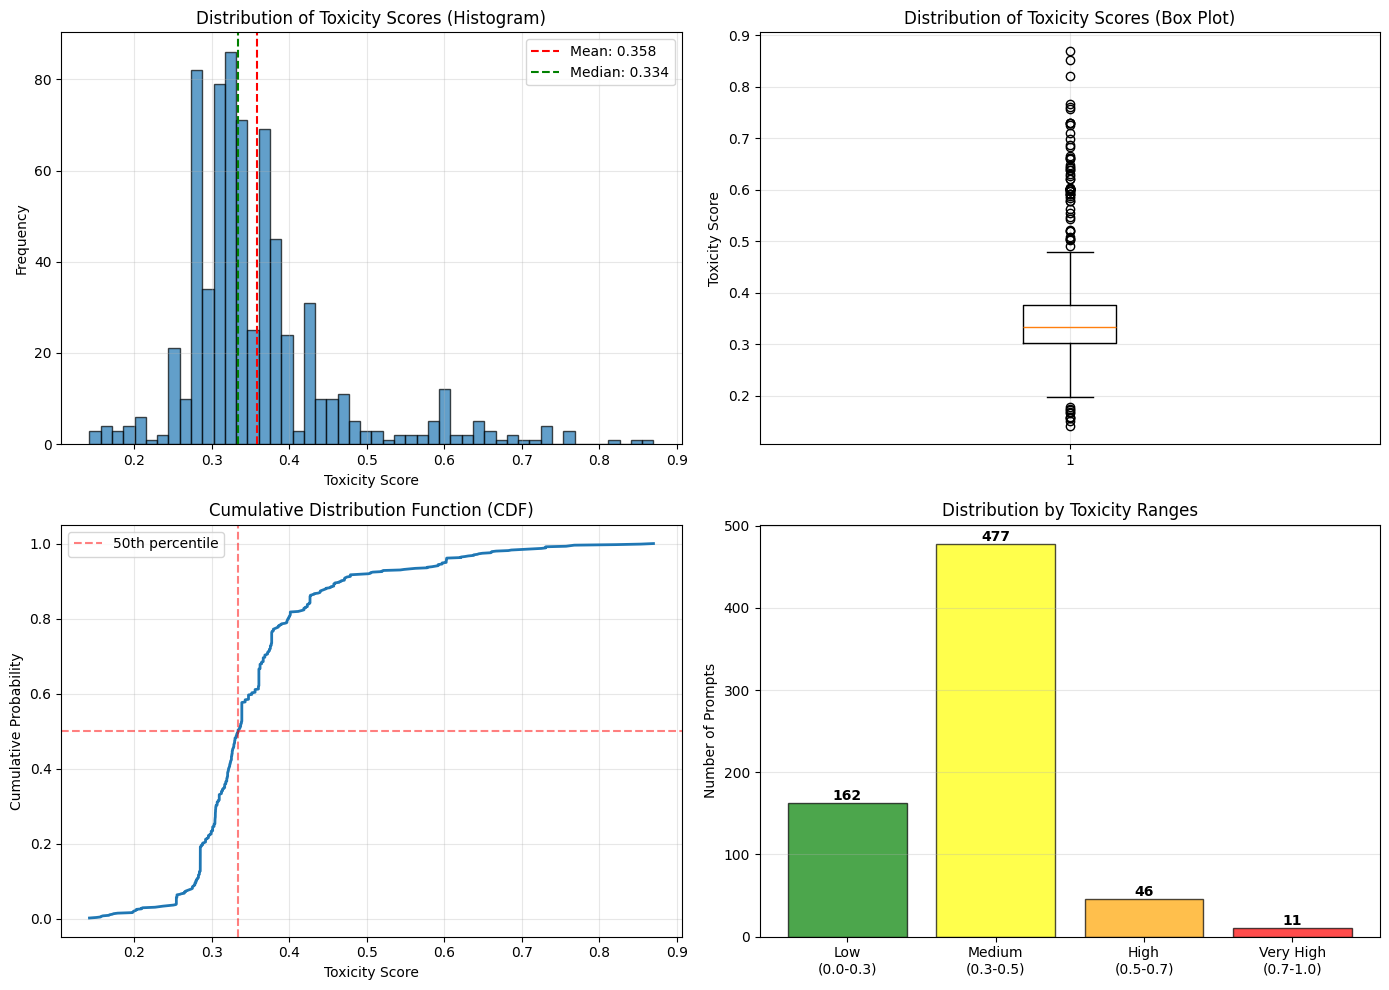


Total prompts analyzed: 696


In [145]:
# Visualize distribution
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Histogram
axes[0, 0].hist(toxicity_scores, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(np.mean(toxicity_scores), color='red', linestyle='--', label=f'Mean: {np.mean(toxicity_scores):.3f}')
axes[0, 0].axvline(np.median(toxicity_scores), color='green', linestyle='--', label=f'Median: {np.median(toxicity_scores):.3f}')
axes[0, 0].set_xlabel('Toxicity Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Toxicity Scores (Histogram)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot
axes[0, 1].boxplot(toxicity_scores, vert=True)
axes[0, 1].set_ylabel('Toxicity Score')
axes[0, 1].set_title('Distribution of Toxicity Scores (Box Plot)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Cumulative Distribution Function (CDF)
sorted_scores = np.sort(toxicity_scores)
cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
axes[1, 0].plot(sorted_scores, cumulative, linewidth=2)
axes[1, 0].axhline(0.5, color='red', linestyle='--', alpha=0.5, label='50th percentile')
axes[1, 0].axvline(np.median(toxicity_scores), color='red', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Toxicity Score')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].set_title('Cumulative Distribution Function (CDF)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Bar chart by ranges
ranges = ['Low\n(0.0-0.3)', 'Medium\n(0.3-0.5)', 'High\n(0.5-0.7)', 'Very High\n(0.7-1.0)']
counts = [
    sum(1 for s in toxicity_scores if 0.0 <= s < 0.3),
    sum(1 for s in toxicity_scores if 0.3 <= s < 0.5),
    sum(1 for s in toxicity_scores if 0.5 <= s < 0.7),
    sum(1 for s in toxicity_scores if 0.7 <= s <= 1.0)
]
colors = ['green', 'yellow', 'orange', 'red']
axes[1, 1].bar(ranges, counts, color=colors, alpha=0.7, edgecolor='black')
axes[1, 1].set_ylabel('Number of Prompts')
axes[1, 1].set_title('Distribution by Toxicity Ranges')
axes[1, 1].grid(True, alpha=0.3, axis='y')
# Add count labels on bars
for i, count in enumerate(counts):
    axes[1, 1].text(i, count, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal prompts analyzed: {len(toxicity_scores)}")
